# Climate causal models
This notebook serves to demonstrate how we define, initialize, and generate dataset for the climate applications. In particular, we adapt implementations from:

- [1] Coupled atmosphere-ocean dynamics: https://github.com/Climdyn/qgs/blob/master/notebooks/maooam_run.ipynb
- [2] Coupled ENSO dynamics: Reference: https://github.com/senclimate/XRO

Full script to process the dataset can be found at `scripts/generate_climate.py`, including the decoupled experiments for ENSO dynamics.

In [1]:
%load_ext autoreload
%autoreload 2

# Coupled Atmosphere-Ocean Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':12})

import warnings
warnings.filterwarnings('ignore')

from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic, OceanicLayerStreamfunctionDiagnostic
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic, OceanicLayerTemperatureAnomalyDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic, GeopotentialHeightDifferenceDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic


First, we define the parameters to initialize the model, using mostly default settings as in the original implementation.

In [3]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams()

# Mode truncation at the wavenumber 2 in both x and y spatial
# coordinates for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)
# Mode truncation at the wavenumber 2 in the x and at the 
# wavenumber 4 in the y spatial coordinates for the ocean
model_parameters.set_oceanic_basin_fourier_modes(2, 4)
model_parameters.set_params({'kd': 0.0290, 'kdp': 0.0290, 'n': 1.5, 'r': 1.e-7, 'h': 136.5, 'd': 1.1e-7})
model_parameters.atemperature_params.set_params({'eps': 0.7, 'T0': 289.3, 'hlambda': 15.06})
model_parameters.gotemperature_params.set_params({'gamma': 5.6e8, 'T0': 301.46})
model_parameters.atemperature_params.set_insolation(103.3333, 0)
model_parameters.gotemperature_params.set_insolation(310, 0)

# Solution and integration parameters
dt = 0.1 # Time parameters
write_steps = 100 # Saving the model state n steps
number_of_trajectories = 1 # Generate only one trajectory for now


In [4]:
%%time
f, Df = create_tendencies(model_parameters)


CPU times: user 9.22 s, sys: 480 ms, total: 9.7 s
Wall time: 9.02 s


In [5]:
%%time
# Integration might take several minutes, depending on your cpu computational power.
integrator = RungeKuttaIntegrator()
integrator.set_func(f)
ic = np.random.rand(model_parameters.ndim) * 0.01 ## Set ICs
ic[29] = 3.  # Setting reasonable initial reference temperature
ic[10] = 1.5
integrator.integrate(0., 2000000.1, dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()


CPU times: user 119 ms, sys: 381 ms, total: 500 ms
Wall time: 1min 42s


In [6]:
%%time
# Discard warmup, and rerun with last trajectory
integrator.integrate(0., 500000., dt, ic=ic, write_steps=write_steps)
reference_time, reference_traj = integrator.get_trajectories()


CPU times: user 36.7 ms, sys: 52 ms, total: 88.7 ms
Wall time: 28.6 s


Now we extract the fields.

In [7]:
# For the 500hPa atmospheric temperature:
psi_a = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, delta_x=0.2, delta_y=0.2, geopotential=True)
# For the 500hPa atmospheric temperature:
theta_a = MiddleAtmosphericTemperatureDiagnostic(model_parameters, delta_x=0.2, delta_y=0.2)
# For the ocean streamfunction:
psi_o = OceanicLayerStreamfunctionDiagnostic(model_parameters, delta_x=0.2, delta_y=0.2)
# For the ocean temperature anomaly:
delta_o = OceanicLayerTemperatureAnomalyDiagnostic(model_parameters, delta_x=0.2, delta_y=0.2)


In [8]:
# Sample and post-process data
n_samples = 2000
inds = np.linspace(0, len(reference_time) - 1, n_samples, dtype=int)

time = reference_time[inds]
traj = reference_traj[:, inds]

m = MultiDiagnostic(2,3)
m.add_diagnostic(psi_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(theta_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(psi_o, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(delta_o, diagnostic_kwargs={'show_time':False})
m.set_data(time, traj)


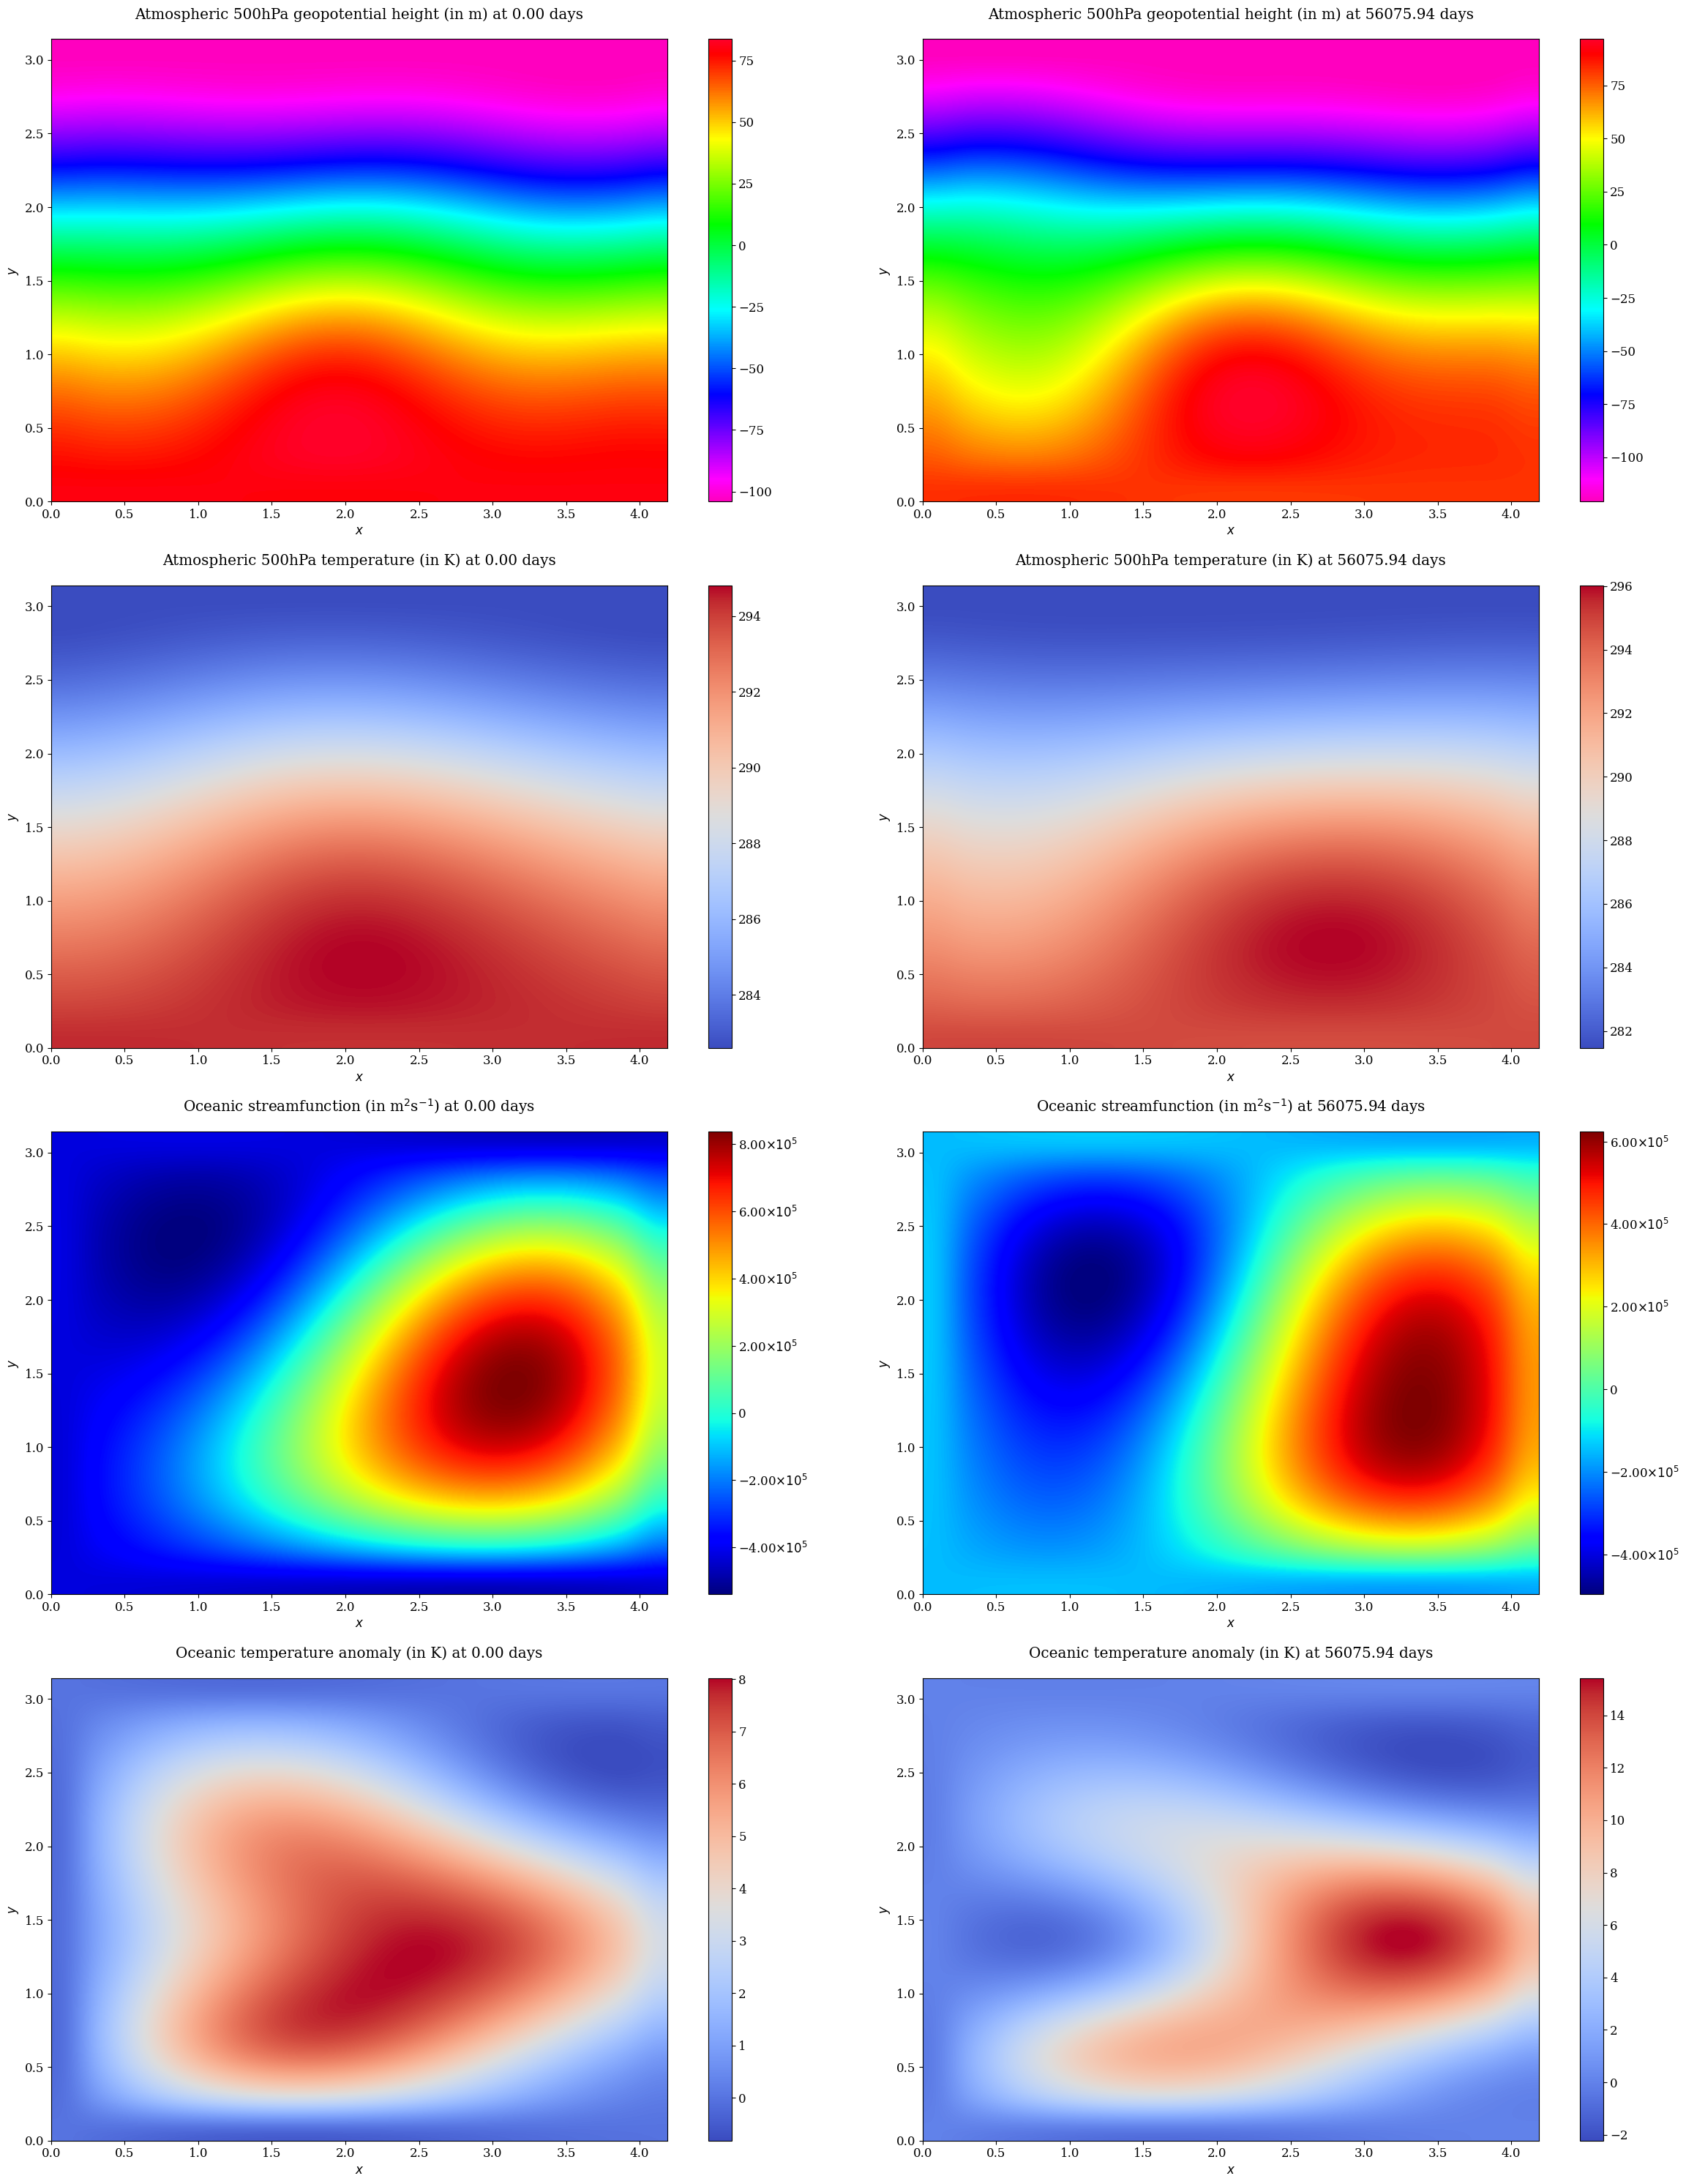

In [9]:
# Plot fields at initial and final snapshot
fig, axs = plt.subplots(4, 2, figsize=(24, 30))

for _, time_idx in enumerate([0, time.shape[0] - 1]):
    psi_a.plot(time_idx, ax=axs[0,_])
    theta_a.plot(time_idx, ax=axs[1,_])
    psi_o.plot(time_idx, ax=axs[2,_])
    delta_o.plot(time_idx, ax=axs[3,_])

plt.tight_layout()
plt.show();


# Coupled ENSO Modes

In [10]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import xarray as xr
from src.causaldynamics.idealized.xro import XRO

# XRO model with annual mean, annual cycle, and semi-annual cycle
XROac2 = XRO(ncycle=12, ac_order=2)


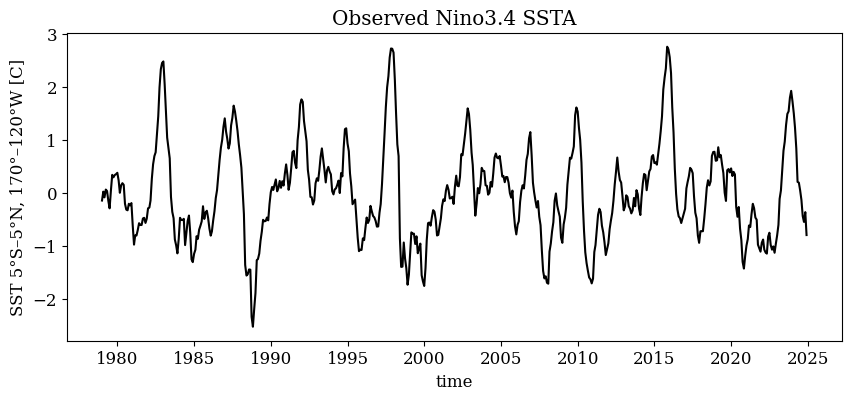

In [11]:
# Load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;

obs_ds = xr.open_dataset('../src/causaldynamics/idealized/XRO_indices_oras5.nc')

# Plot the observed SST timeseries
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
obs_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_title('Observed Nino3.4 SSTA')
train_ds = obs_ds.sel(time=slice('1979-01', '2022-12'))


In [12]:
# Fit the model with observation: hyperparameters follow the control experiment as described in the original paper
XROac2_fit = XROac2.fit_matrix(train_ds, maskb=['IOD'], maskNT=['T2', 'TH'])


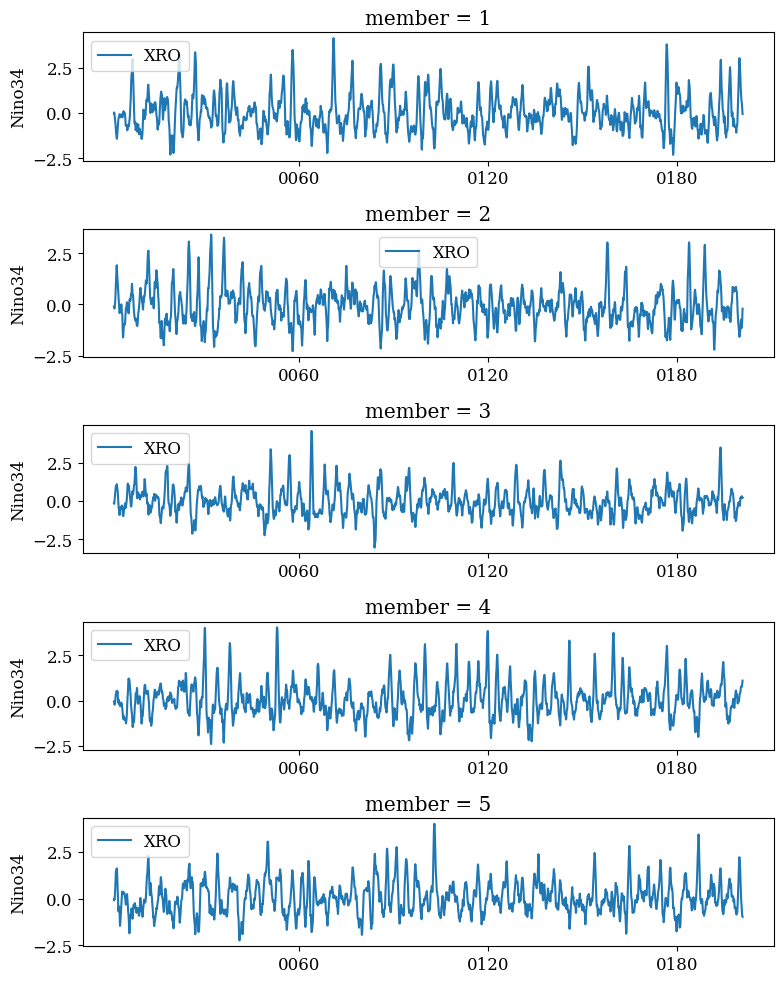

In [13]:
# Generate data (with e.g., 5 members) + visualize ENSO SST
XROac2_sim = XROac2.simulate(fit_ds=XROac2_fit, X0_ds=train_ds.isel(time=0), nyear=200, ncopy=100, is_xi_stdac=False, seed=42)  

nmember=5
fig, axes = plt.subplots(nmember, 1, figsize=(8, nmember * 2), layout='compressed')

for i, ax in enumerate(axes.flat):
    XROac2_sim.isel(member=i+1)['Nino34'].plot(ax=ax, c='C0', lw=1.5, label='XRO')
    ax.set_xlabel('')
    ax.legend()

plt.tight_layout()
plt.show();
